In [ ]:
#Import needed packages

from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import Adam

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers =nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(3, 32, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),

                
            # Defining another 2D convolution layer
            nn.Conv2d(32, 64, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            # third layer
            nn.Conv2d(64, 128,kernel_size=2,stride=1,padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=2),
            # fourth layer
            nn.Conv2d(128,128,kernel_size=2,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_features=128),
            nn.AvgPool2d(kernel_size=4)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(128, 10))

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 128)
        x = self.linear_layers(x)
        return x

In [ ]:
#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

#Load the training set
train_set = CIFAR10(root="./data",train=True,transform=train_transformations,download=True)

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)


#Define transformations for the test set
test_transformations = transforms.Compose([
   transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

])

#Load the test set, note that train is set to False
test_set = CIFAR10(root="./data",train=False,transform=test_transformations,download=True)

#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=4)
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Check if gpu support is available
cuda_avail = torch.cuda.is_available()

#Create model, optimizer and loss function
#model = Net(num_classes=10)
model = Net()
if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        #prediction = prediction.numpy()
        test_acc += torch.sum(prediction == labels.data).item()
        


    #Compute the average acc and loss over all 10000 test images
    test_acc = test_acc / 10000

    return test_acc

In [ ]:
def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            outputs = model(images)
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

            train_loss += loss.data.item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data).item()



        #Compute the average acc and loss over all 50000 training images
        train_acc = train_acc / 50000
        train_loss = train_loss / 50000

        #Evaluate on the test set
        test_acc = test()



        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))


if __name__ == "__main__":
    train(100)  # 200


Epoch 0, Train Accuracy: 0.69566 , TrainLoss: 0.8739389067077636 , Test Accuracy: 0.7139
Epoch 1, Train Accuracy: 0.71826 , TrainLoss: 0.807288300857544 , Test Accuracy: 0.7228
Epoch 2, Train Accuracy: 0.73748 , TrainLoss: 0.7593298344802857 , Test Accuracy: 0.7058
Epoch 3, Train Accuracy: 0.7482 , TrainLoss: 0.7227293885421753 , Test Accuracy: 0.7585
Epoch 4, Train Accuracy: 0.76066 , TrainLoss: 0.6933876021385192 , Test Accuracy: 0.7559
Epoch 5, Train Accuracy: 0.76706 , TrainLoss: 0.6732855082988739 , Test Accuracy: 0.7587
Epoch 6, Train Accuracy: 0.7741 , TrainLoss: 0.6533442441654206 , Test Accuracy: 0.7833
Epoch 7, Train Accuracy: 0.78048 , TrainLoss: 0.6299200036430359 , Test Accuracy: 0.7845
Epoch 8, Train Accuracy: 0.78532 , TrainLoss: 0.6198941094875335 , Test Accuracy: 0.7969
Epoch 9, Train Accuracy: 0.78866 , TrainLoss: 0.6073905242633819 , Test Accuracy: 0.7947
Epoch 10, Train Accuracy: 0.79524 , TrainLoss: 0.5911310897254943 , Test Accuracy: 0.7903
Epoch 11, Train Accurac

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
test_loss = 0.0
model.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        # calculate the batch loss
        loss = loss_fn(outputs, labels)
        # update test loss 
        test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.501396

Accuracy of airplane : 82 %
Accuracy of automobile : 89 %
Accuracy of  bird : 71 %
Accuracy of   cat : 64 %
Accuracy of  deer : 84 %
Accuracy of   dog : 83 %
Accuracy of  frog : 94 %
Accuracy of horse : 86 %
Accuracy of  ship : 92 %
Accuracy of truck : 87 %

Test Accuracy (Overall): 83% (1041/1252)


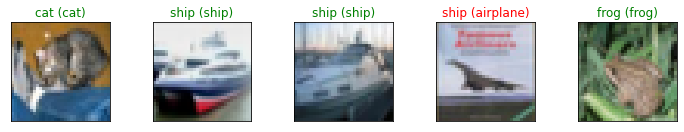

In [ ]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))


# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if cuda_avail:
  images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())
if cuda_avail:
    images = images.cuda()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))